### Library Import

In [379]:
import os
from typing import List, Dict
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import lightgbm as lgb
from plotly.subplots import make_subplots
import plotly.graph_objects as go


### Data Load

In [380]:
# 파일 호출
data_path: str = "/data/ephemeral/home/BTC/data"
train_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "train.csv")).assign(_type="train") # train 에는 _type = train 
test_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")).assign(_type="test") # test 에는 _type = test
submission_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")) # ID, target 열만 가진 데이터 미리 호출
df: pd.DataFrame = pd.concat([train_df, test_df], axis=0)

In [381]:
# HOURLY_ 로 시작하는 .csv 파일 이름을 file_names 에 할딩
file_names: List[str] = [
    f for f in os.listdir(data_path) if f.startswith("HOURLY_") and f.endswith(".csv")
]

# 파일명 : 데이터프레임으로 딕셔너리 형태로 저장
file_dict: Dict[str, pd.DataFrame] = {
    f.replace(".csv", ""): pd.read_csv(os.path.join(data_path, f)) for f in file_names
}

for _file_name, _df in tqdm(file_dict.items()):
    # 열 이름 중복 방지를 위해 {_file_name.lower()}_{col.lower()}로 변경, datetime 열을 ID로 변경
    _rename_rule = {
        col: f"{_file_name.lower()}_{col.lower()}" if col != "datetime" else "ID"
        for col in _df.columns
    }
    _df = _df.rename(_rename_rule, axis=1)
    df = df.merge(_df, on="ID", how="left")


100%|██████████| 107/107 [00:02<00:00, 37.42it/s]


### EDA (Explanatory Data Analysis)

### Feature engineering

In [382]:
from data_preprocessing import *

In [383]:
# 모델에 사용할 컬럼, 컬럼의 rename rule을 미리 할당함
cols_dict: Dict[str, str] = {
    "ID": "ID",
    "target": "target",
    "_type" : "_type",
    "hourly_market-data_funding-rates_all_exchange_funding_rates": "funding_rates",
    "hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations": "long_liquidations",
    "hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations": "short_liquidations",
    "hourly_market-data_open-interest_all_exchange_all_symbol_open_interest": "open_interest",
    "hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close": "close",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_volume": "taker_buy_volume",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_volume": "taker_sell_volume",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_ratio": "taker_buy_ratio",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_ratio": "taker_sell_ratio",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_sell_ratio": "taker_buy_sell_ratio",
    "hourly_network-data_addresses-count_addresses_count_active": "addresses_count_active",
    "hourly_network-data_addresses-count_addresses_count_sender": "addresses_count_sender",
    "hourly_network-data_addresses-count_addresses_count_receiver": "addresses_count_receiver",
    "hourly_network-data_block-bytes_block_bytes": "block_bytes",
    "hourly_network-data_block-count_block_count": "block_count",
    "hourly_network-data_block-interval_block_interval": "block_interval",
    "hourly_network-data_blockreward_blockreward": "blockreward",
    "hourly_network-data_difficulty_difficulty": "difficulty",
    "hourly_network-data_fees_fees_block_mean": "fees_block_mean",
    "hourly_network-data_fees_fees_total": "fees_total",
    "hourly_network-data_fees_fees_reward_percent": "fees_reward_percent",
    "hourly_network-data_fees-transaction_fees_transaction_mean": "fees_transaction_mean",
    "hourly_network-data_fees-transaction_fees_transaction_median": "fees_transaction_median",
    "hourly_network-data_hashrate_hashrate": "hashrate",
    "hourly_network-data_supply_supply_total": "supply_total",
    "hourly_network-data_supply_supply_new": "supply_new",
    "hourly_network-data_tokens-transferred_tokens_transferred_total": "tokens_transferred_total",
    "hourly_network-data_tokens-transferred_tokens_transferred_mean": "tokens_transferred_mean",
    "hourly_network-data_tokens-transferred_tokens_transferred_median": "tokens_transferred_median",
    "hourly_network-data_transactions-count_transactions_count_total": "transactions_count_total",
    "hourly_network-data_transactions-count_transactions_count_mean": "transactions_count_mean",
    "hourly_network-data_utxo-count_utxo_count": "utxo_count",
    "hourly_network-data_velocity_velocity_supply_total": "velocity_supply_total"
}
df = df[cols_dict.keys()].rename(cols_dict, axis=1)
df.shape

(11552, 36)

In [384]:
# continuous 열을 따로 할당해둠
conti_cols: List[str] = [
    "close",
    "open_interest",
    "difficulty",
    "supply_total",
    "utxo_count"
]

# 최대 24시간의 shift 피쳐를 계산
shift_list = shift_feature(
    df=df, conti_cols=conti_cols, intervals=[_ for _ in range(1, 24)]
)

# concat 하여 df 에 할당
df = pd.concat([df, pd.concat(shift_list, axis=1)], axis=1)

In [385]:
# _type에 따라 train, test 분리
train_df = df.loc[df["_type"]=="train"].drop(columns=["_type"])
test_df = df.loc[df["_type"]=="test"].drop(columns=["_type"])

## Model Training
### LightGBM + GridsearchCV

In [386]:
from sklearn.model_selection import KFold
import optuna

X_train = train_df.drop(["ID", "target", "close"], axis=1)
y_train = train_df["close"]
target = train_df["target"]

In [387]:
def close_to_class(series: pd.Series) -> pd.Series:
    """close 변수를 target값으로 변환하는 함수입니다.

    Args:
        series (pd.Series): 변환을 원하는 close 변수

    Returns:
        pd.Series: 변환된 target 값
    """
    close = pd.DataFrame()
    close['close'] = series
    close['close_lag1'] = close['close'].shift(1)
    close['close_lag1_percent'] = (close['close'] - close['close_lag1']) / close['close_lag1']
    close['class'] = close['close']
    for i in range(close.shape[0]):
        if close.loc[i, 'close_lag1_percent'] < -0.005:
            close.loc[i, 'class'] = 0
        elif close.loc[i, 'close_lag1_percent'] < 0:
            close.loc[i, 'class'] = 1
        elif close.loc[i, 'close_lag1_percent'] < 0.005:
            close.loc[i, 'class'] = 2
        else:
            close.loc[i, 'class'] = 3
            
    return close["class"].shift(-1).fillna(method="ffill")

In [388]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import warnings
warnings.filterwarnings("ignore")

def evaluate(valid_target, y_valid, y_pred, metric):
    if metric == "accuracy":
        classes_pred = close_to_class(y_pred)
        return accuracy_score(valid_target, classes_pred)
    if metric == "mae":
        return mean_absolute_error(y_valid, y_pred)
    if metric == "mse":
        return mean_squared_error(y_valid, y_pred)
    if metric == "mape":
        mae = mean_absolute_percentage_error(y_valid, y_pred)
        return mae

In [389]:
def model_train(model, X_train, y_train, cv, metric):
    #kfold = KFold(n_splits=cv, shuffle=True, random_state=42)
    kfold = KFold(n_splits=cv)
    score_list = []
    fold_model = []

    if hasattr(model, "warm_start"):
        model.warm_start = True
        
    for train_index, valid_index in kfold.split(X_train):
        X_train_fold, y_train_fold = X_train.iloc[train_index], y_train.iloc[train_index]
        X_valid, y_valid = X_train.iloc[valid_index], y_train.iloc[valid_index]
        
        vaild_target = target[valid_index]

        # preprocessing
        X_train_fold.fillna(X_train_fold.mean(), inplace=True)
        X_valid.fillna(X_valid.mean(), inplace=True)

        #model.fit(X_train_fold.drop("target", axis=1), y_train_fold)
        #y_pred = model.predict(X_valid.drop("target", axis=1))
        model.fit(X_train_fold, y_train_fold)
        fold_model.append(model)

        y_pred = model.predict(X_valid)
        score = evaluate(vaild_target, y_valid, y_pred, metric=metric)
        score_list.append(score)
    
    return fold_model[np.argmax(score_list)], np.max(score_list)

In [390]:
def objective(trial):
    # 하이퍼파라미터 설정
    params = {
        "verbose" : -1,
        "num_leaves" : trial.suggest_int("num_leaves", 20, 100),
        "learning_rate" : trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "max_depth" : trial.suggest_int("max_depth", 3, 10), # 과적합 방지
        "min_child_weight" : trial.suggest_int("min_child_weight", 1, 5), # 과소적합 방지
        "subsample" : trial.suggest_uniform("subsample", 0.5, 1.0), # 데이터 샘플링 비율, 과적합 방지
        "colsample_bytree" : trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
        # # 정규화 파라미터 범위 조정
        # "reg_alpha" : trial.suggest_loguniform("reg_alpha", 1e-3, 1.0), 
        # "reg_lambda" : trial.suggest_loguniform("reg_lambda", 1e-3, 1.0),
        "random_state" : 42,
        #"force_col_wise": True,
        #"device" : "gpu", 
    }

    lgb_model = lgb.LGBMRegressor(**params)
    _, acc = model_train(lgb_model, X_train, y_train, cv=5, metric="accuracy")

    return acc


In [391]:
# optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

# best params
print("Best Hyperparameters: ", study.best_params)

[I 2024-09-24 23:41:41,677] A new study created in memory with name: no-name-9a717d0f-5d75-48a4-8b56-b2faf531ab78
[I 2024-09-24 23:41:48,094] Trial 0 finished with value: 0.5958904109589042 and parameters: {'num_leaves': 28, 'learning_rate': 0.015394292645225651, 'n_estimators': 291, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.6464305465312234, 'colsample_bytree': 0.7453001358654181}. Best is trial 0 with value: 0.5958904109589042.
[I 2024-09-24 23:41:57,298] Trial 1 finished with value: 0.5896118721461188 and parameters: {'num_leaves': 100, 'learning_rate': 0.016180241140479393, 'n_estimators': 156, 'max_depth': 8, 'min_child_weight': 1, 'subsample': 0.515040609462805, 'colsample_bytree': 0.8627075296207913}. Best is trial 0 with value: 0.5958904109589042.
[I 2024-09-24 23:42:01,952] Trial 2 finished with value: 0.4452054794520548 and parameters: {'num_leaves': 21, 'learning_rate': 0.004389378036513931, 'n_estimators': 189, 'max_depth': 5, 'min_child_weight': 5, 'subsample':

Best Hyperparameters:  {'num_leaves': 26, 'learning_rate': 0.04213035356731288, 'n_estimators': 185, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.6935152618288704, 'colsample_bytree': 0.817078550414085}


In [392]:
# 최적의 모델
best_params = study.best_params
best_lgb_model= lgb.LGBMRegressor(**best_params, random_state=42)

In [393]:
LightGBM_model, accuracy = model_train(best_lgb_model, X_train, y_train, cv=5, metric="accuracy")

print("LGB model accuracy:", accuracy)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31456
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 147
[LightGBM] [Info] Start training from score 30562.564983
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

### Inference

In [394]:
X_train = fill_feature(X_train, method="mean")
LightGBM_model.fit(X_train, y_train)

X_test = test_df.drop(["ID", "target", "close"], axis=1)

# 결측치 처리
X_test.fillna(X_test.mean(), inplace=True)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003734 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31611
[LightGBM] [Info] Number of data points in the train set: 8760, number of used features: 147
[LightGBM] [Info] Start training from score 28797.311296
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

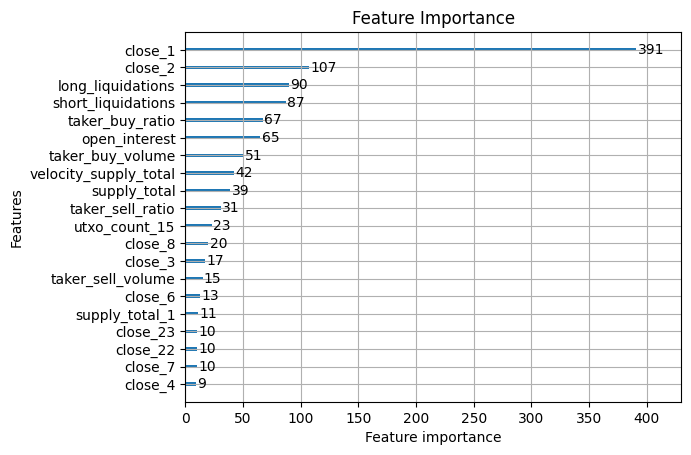

In [395]:
import matplotlib.pyplot as plt
# Feature Importance 시각화
lgb.plot_importance(LightGBM_model, max_num_features=20, importance_type='split')  # 또는 importance_type='gain'
plt.title("Feature Importance")
plt.show()

In [396]:
# lgb predict
y_test_pred = LightGBM_model.predict(X_test)
y_test_pred_class = close_to_class(y_test_pred) # 예측 결과를 범주형 변수로 변환

### Output File Save

In [398]:
# output file 할당후 save 
submission_df = submission_df.assign(target = y_test_pred_class)
submission_df["target"] = submission_df["target"].astype(np.int8)
submission_df.to_csv("output.csv", index=False)